In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import lxml
from lxml import objectify

import time

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pyproj
import json


In [8]:
path = 'testdata/2hr_events.xml'
xml = objectify.parse(open(path))

In [9]:
netpath = 'testdata/NYOSMnetwork_25cap.xml'
netxml = objectify.parse(open(netpath))

In [10]:
root = xml.getroot()

In [11]:
events = root.getchildren()

In [12]:
netroot = netxml.getroot()

In [13]:
G = nx.DiGraph()
pos = {}
edges = {}
# add nodes
for n in netroot.getchildren()[0].getchildren():
    nid = n.get('id')
    x = float(n.get('x'))
    y = float(n.get('y'))
    pos[nid] = (x, y)
    G.add_node(n.get('id'), x = x, y = y)

for e in netroot.getchildren()[1].getchildren():
    eid = e.get('id')
    i = e.get('from')
    j = e.get('to')
    capacity = e.get('capacity')
    G.add_edge(i,j, id=eid, capacity=capacity)
    edges[eid] = (i,j)

In [14]:
eventdf = []

for e in events:
    eventdf.append({k:e.get(k) for k in e.keys()})

In [15]:
eventdf = pd.DataFrame(eventdf)

In [16]:
eventdf['time'] = pd.to_numeric(eventdf['time'])

In [17]:
eventdf.columns

Index([u'actType', u'legMode', u'link', u'networkMode', u'person',
       u'relativePosition', u'time', u'type', u'vehicle'],
      dtype='object')

In [18]:
len(eventdf['vehicle'].unique())

7616

### Type of events

#### Passenger related
- actend : dummy, ignore
- departure : a passenger requests taxi
- PersonEntersVehicle : passenger enters taxi
- PersonLeavesVehicle : passenger leaves taxi
- arrival  : taxi trip ends (same time as PersonLeavesVehicle)

#### Rebalancing related
Actually, we will tag as rebalancing whenever there is no passenger inside... which, is interesting. 


In [19]:
def get_location_time_tuple(link_id, enter_time, exit_time):
    #NOTE: ASSUMES FLOAT IN THE TIMES
    # get the start and end locations
    i,j  = edges[link_id]
    x0 = G.node[i]['x']
    y0 = G.node[i]['y']
    x1 = G.node[j]['x']
    y1 = G.node[j]['y']
    
    #print x0,y0, '\t', x1, y1
    # get proportions at steps 
    props  = ( np.arange(enter_time, exit_time + 1) - (enter_time) )/ (exit_time - enter_time)
    x = (x1 - x0) * props + x0
    y = (y1 - y0) * props + y0
    return x,y

In [20]:
v_ids = eventdf['vehicle'].unique()[~pd.isnull(eventdf['vehicle'].unique())]

In [21]:
times = np.arange(0,eventdf['time'].max())
v_timeseries = {}
for i in v_ids:
    v_timeseries[i] = {
        'x': np.zeros(int(eventdf['time'].max() + 1)),
        'y': np.zeros(int(eventdf['time'].max() + 1)),
        'status': np.zeros(int(eventdf['time'].max() + 1)) # (0,1,2) - (idle, pax, reb)
    }

In [22]:
movedf = eventdf[~pd.isnull(eventdf['vehicle']) & 
                 (~pd.isnull(eventdf['link']))]

pickdf = eventdf[~pd.isnull(eventdf['vehicle']) & 
                 (~pd.isnull(eventdf['person'])) &
                 (eventdf['person'] != eventdf['vehicle'])]

In [23]:
len(pickdf)

110664

In [25]:
t0 = time.time()
for v,v_id in enumerate(v_ids):
    # get a dataframe of the traffic events
    t1 = time.time()
    df = movedf[(movedf['vehicle'] == v_id)]
    ddf1 = time.time() - t1
    
    # split it into groups
    grps = np.array_split(df, len(df)/2)
    
    # this is to track idle times
    last_endtime = 0.
    tloop1 = []
    for i,g in enumerate(grps):
        t1  = time.time()
        #link = g.iloc[0]['link']
        #assert link == g.iloc[1]['link']
        
        start_time = g.iloc[0]['time']
        end_time = g.iloc[1]['time']
        
        
        x,y = get_location_time_tuple(g.iloc[0]['link'], start_time, end_time)
        
        
        
        # if it's the first group, all previous locations should be here
        if i == 0:
            v_timeseries[v_id]['x'][:int(start_time)+1] = x[0]
            v_timeseries[v_id]['y'][:int(start_time)+1] = y[0]
        #if it's the final group, then it remains where it should
        elif i == len(grps) - 1:
            v_timeseries[v_id]['x'][int(end_time):] = x[-1]
            v_timeseries[v_id]['y'][int(end_time):] = y[-1]
        # fill the idle times
        elif start_time != last_endtime:
            v_timeseries[v_id]['x'][int(last_endtime):int(start_time)] = x[0]
            v_timeseries[v_id]['y'][int(last_endtime):int(start_time)] = y[0]
        
        v_timeseries[v_id]['x'][int(start_time):int(end_time) + 1] = x
        v_timeseries[v_id]['y'][int(start_time):int(end_time) + 1] = y
        # default to rebalance (easier to check if a vehicle has a passenger)
        v_timeseries[v_id]['status'][int(start_time):int(end_time) + 1] = 2
        last_endtime = end_time
        tloop1.append(time.time() - t1)
    
    # get a dataframe of the pickup events
    t1 = time.time()
    df = pickdf[(pickdf['vehicle'] == v_id)]
    ddf2 = time.time() - t1
    
    # split it into groups
    if len(df) > 0:
        grps = np.array_split(df, len(df)/2)
    else:
        continue
    
    tloop2 = []
    for i,g in enumerate(grps):
        t1 = time.time()
        person = g.iloc[0]['person']
        assert person == g.iloc[1]['person']
        
        start_time = g.iloc[0]['time']
        end_time = g.iloc[1]['time']
        
        v_timeseries[v_id]['status'][int(start_time):int(end_time) + 1] = 1
        tloop2.append(time.time() - t1)
        
dt = time.time() - t0

/Users/ramoniglesias/development/matsim-viz/venv/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide


In [62]:
v_id = v_ids[4900]

In [60]:
dt

8979.962336063385

In [28]:
mask0 = v_timeseries[v_id]['status'] == 0
mask1 = v_timeseries[v_id]['status'] == 1
mask2 = v_timeseries[v_id]['status'] == 2

In [29]:
treb = sum(mask2) / float(len(v_timeseries[v_id]['status']))
tpax = sum(mask1) / float(len(v_timeseries[v_id]['status']))
tidl = sum(mask0) / float(len(v_timeseries[v_id]['status']))

print 'Pax: {} \t Reb: {} \t Idl: {}'.format(tpax, treb, tidl)

Pax: 0.180909175076 	 Reb: 0.177113230256 	 Idl: 0.641977594667


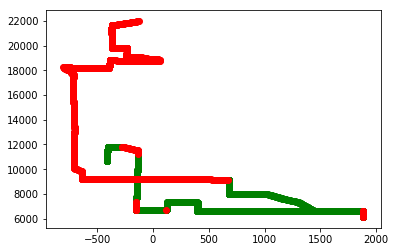

In [63]:
plt.scatter(v_timeseries[v_id]['x'][mask1],v_timeseries[v_id]['y'][mask1], color='g')
plt.scatter(v_timeseries[v_id]['x'][mask2],v_timeseries[v_id]['y'][mask2], color='r')

In [31]:
geod = pyproj.Geod(ellps='WGS84')
refLoc = [40.6892, -74.0444]
angleShift = 28.8
def to_latlon(x, y, refLoc=refLoc):
    pos = np.concatenate((x[:,None],y[:,None]), axis=1)
    d = np.linalg.norm(pos, axis=1)
    a = np.nan_to_num(np.degrees(np.arctan(x/y)) + 28.8) # nan_to_num to deal for x = y = 0
    lons, lats, azs = geod.fwd(np.repeat(refLoc[1], len(pos)), np.repeat(refLoc[0], len(pos)), a, d)
    return lats, lons

In [64]:
lat,lon = to_latlon(v_timeseries[v_id]['x'], v_timeseries[v_id]['y'])

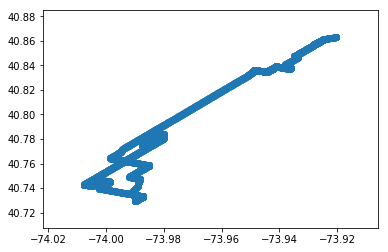

In [65]:
plt.scatter(lon,lat)

array([-73.92026103, -73.92026103, -73.92026103, ..., -73.98767665,
       -73.98767665, -73.98767665])

In [67]:
data = np.concatenate((lat[:,None],lon[:,None], status[:,None]), axis=1)

In [68]:
with open('testdata/single_car.json','w') as f:
    json.dump({'loc': data.tolist()}, f)

In [42]:
tarr = np.array([
    [
        [1,2,3],
        [2,4,6],
        [3,8,9]
    ],
    [
        [4,5,6],
        [8,10,12],
        [12,15,18]
    ]
])

In [663]:
np.stack((tarr[0], tarr[1]), axis = 1)

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 2,  4,  6],
        [ 8, 10, 12]],

       [[ 3,  8,  9],
        [12, 15, 18]]])

In [48]:
tempArrays = [];
for i,v_id in enumerate(v_ids):
    x = np.nan_to_num(v_timeseries[v_id]['x'])
    y = np.nan_to_num(v_timeseries[v_id]['y'])
    lat,lon = to_latlon(x, y)
    tempArrays.append(
        np.concatenate((lat[:,None], lon[:,None], v_timeseries[v_id]['status'][:,None]), axis = 1)
    )

data = np.concatenate(tempArrays, axis=1)

/Users/ramoniglesias/development/matsim-viz/venv/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


In [80]:
data = np.concatenate(tempArrays, axis=1)

In [86]:
minutes = [i * 60 for i in range(10800 / 60)]

In [89]:
data[minutes].shape

(180, 22845)

In [91]:
pd.DataFrame(data[minutes]).to_csv('testdata/2hr_minutes.csv')

In [93]:
with open('testdata/2hr_min.json','w') as f:
    json.dump({'loc': data[minutes].tolist()}, f)

In [57]:
pd.DataFrame(data).to_csv('testdata/all_2hr.csv')

In [708]:
tempArrays = [];
for i,v_id in enumerate(v_ids):
    x = np.nan_to_num(v_timeseries[v_id]['x'])
    y = np.nan_to_num(v_timeseries[v_id]['y'])
    lat,lon = to_latlon(x, y)
    tempArrays.append(
        np.concatenate((lat[:,None], lon[:,None], v_timeseries[v_id]['status'][:,None]), axis = 1)
    )
data = np.stack(tempArrays, axis = 1)

/Users/ramoniglesias/development/matsim-viz/venv/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


In [106]:
data.shape

(10801, 22845)

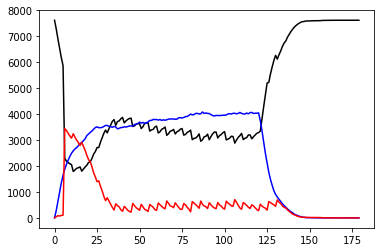

In [119]:
plt.plot((data[minutes][:,range(2,22845,3)] == 0).sum(axis=1), color='black')
plt.plot((data[minutes][:,range(2,22845,3)] == 1).sum(axis=1), color='blue')
plt.plot((data[minutes][:,range(2,22845,3)] == 2).sum(axis=1), color='red')

In [124]:
summary = pd.DataFrame()

In [131]:
summary['time'] = range(0, len(data[minutes]))
summary['idle'] = (data[minutes][:,range(2,22845,3)] == 0).sum(axis=1)
summary['passenger'] = (data[minutes][:,range(2,22845,3)] == 1).sum(axis=1)
summary['rebalancing'] = (data[minutes][:,range(2,22845,3)] == 2).sum(axis=1)
summary = summary.set_index('time')

In [132]:
summary.to_csv('testdata/2hr_summary.csv')

In [711]:
with open('testdata/2hr.json','w') as f:
    json.dump({'loc': data.tolist()}, f)

KeyboardInterrupt: 